# Chapter 12 - Reactive flow and the emergence of melt channels

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

## Linearised stability analysis

### The base state

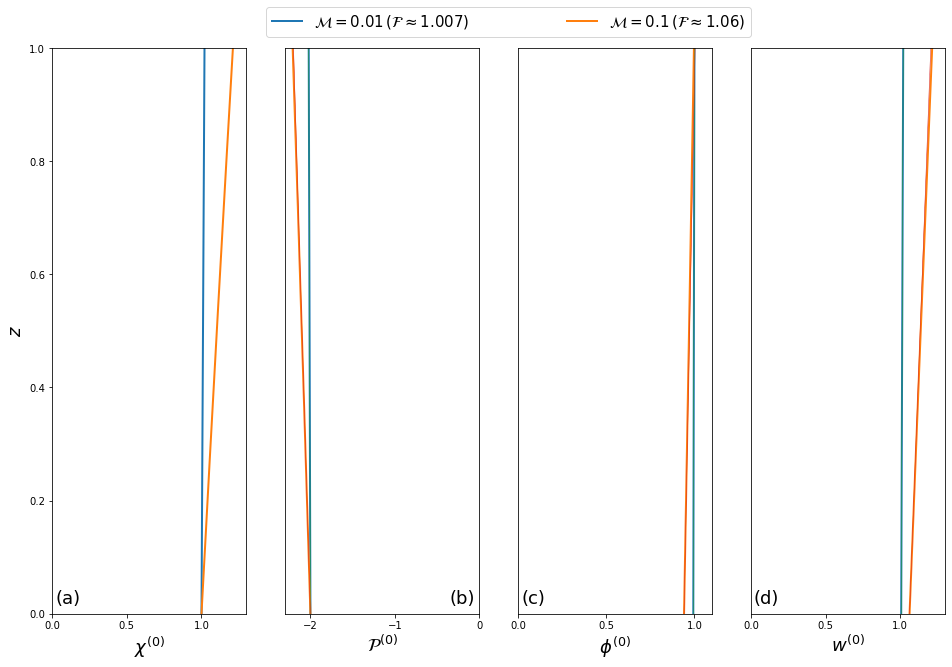

In [2]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

### The growth rate of perturbations

In [19]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, largeDa_=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k)--sigma space
        self.largeDa = largeDa_

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [4]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual


def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual


def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

  
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M


def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

In [5]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)
    # if len(np.nonzero(gP < 0)) > 1 and par.bc_type is not 1:  # TODO: check
    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [6]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [17]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = m = np.full((1, 2), np.inf + 0.j, dtype=np.complex) if par.largeDa \
        else np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [8]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: 

SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486
SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.893915333841757
SUCCESS: monotonic eigenfunction for k=2.893915333841757, sigma=1.9686282850231809
Iteration 67: searching for solution at k=2.876959889798782

SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686407760079
Iteration 124: searching for solution at k=2.1709654269636625
SUCCESS: monotonic eigenfunction for k=2.1709654269636625, sigma=1.4006068249236672
Iteration 125: searching for solution at k=2.161931681598373
SUCCESS: monotonic eigenfunction for k=2.161931681598373, sigma=1.3907429250168655
Iteration 126: searching for solution at k=2.1529868742620373
SUCCESS: monotonic eigenfunction for k=2.1529868742620373, sigma=1.3808769365975595
Iteration 127: searching for solution at k=2.1441302403165734
SUCCESS: monotonic eigenfunction for k=2.1441302403165734, sigma=1.3710088537856233
Iteration 128: searching for solution at k=2.13

SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=1.789231921433876
SUCCESS: monotonic eigenfunction for k=1.789231921433876, sigma=0.8339327226432995
Iteration 182: searching for solution at k=1.7851158060094738
SUCCESS: monotonic eigenfunction for k=1.7851158060094738, sigma=0.8238525376988776
Iteration 183: searching for solution at k=1.7811114581620757
SUCCESS: monotonic eigenfunction for k=1.7811114581620757, sigma=0.8137620312321754
Iteration 184: searching for solution at k=1.7772214599445333
SUCCESS: monotonic eigenfunction for k=1.7772214599445333, sigma=0.8036603862297201
Iteration 185: searching for solution at k

SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272
SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution at k=1.9021210169942402
SUCCESS: monotonic eigenfunction for k=1.9021210169942402, sigma=0.2943114912123439
Iteration 237: searching for solution at k=1.9179962823287162
SUCCESS: monotonic eigenfunction for k=1.9179962823287162, sigma=0.285286140682754
Iteration 238: searching for solution at k=1.9349416724183848
SUCCESS: monotonic eigenfunction for k=1.9349416724183848, sigma=0.2763392029513724
Iteration 239: searching for solution at k=1.9530095021639347
SUCCESS: monotonic eigenfunction for k=1.9530095021639347, sigma=0.2674788464232898
Iteration 240: searching for solution at k=1.9722527152480793
SUCCESS: monotonic eigenfunction for k=1.9722527152480793, sigma=0.25871363159658883
Iteration 241: searching for solution at

SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at sigma=0.06660635029342152
FAILURE: non-monotonic eigenfunction for k=3.5538366738626475, sigma=0.06660635029342152
Iteration 272: searching for solution at k=5.058765018033284
SUCCESS: monotonic eigenfunction for k=5.058765018033284, sigma=2.604939080674623
Iteration 273: searching for solution at k=5.119531639910905
SUCCESS: monotonic eigenfunction for k=5.119531639910905, sigma=2.613402987083552
Iteration 274: searching for solution at k=5.181944312819961
SUCCESS: monotonic eigenfunction for k=5.181944312819961, sigma=2.621818793611423
Iteration 275: searching for solution at k=5.246065810533805
SUCCESS: monotonic eigenfunction for k=5.2

SUCCESS: monotonic eigenfunction for k=13.925392063090193, sigma=2.934755273948965
Iteration 330: searching for solution at k=14.241759614198674
SUCCESS: monotonic eigenfunction for k=14.241759614198674, sigma=2.9368941916783893
Iteration 331: searching for solution at k=14.566141043087281
SUCCESS: monotonic eigenfunction for k=14.566141043087281, sigma=2.938922187603193
Iteration 332: searching for solution at k=14.898691378290142
SUCCESS: monotonic eigenfunction for k=14.898691378290142, sigma=2.9408418539304773
Iteration 333: searching for solution at k=15.239570028559925
SUCCESS: monotonic eigenfunction for k=15.239570028559925, sigma=2.9426557367103476
Iteration 334: searching for solution at k=15.588940918361198
SUCCESS: monotonic eigenfunction for k=15.588940918361198, sigma=2.9443663238756232
Iteration 335: searching for solution at k=15.946972608494585
SUCCESS: monotonic eigenfunction for k=15.946972608494585, sigma=2.9459760344852417
Iteration 336: searching for solution at k

SUCCESS: monotonic eigenfunction for k=51.01369828653325, sigma=2.9146864810531894
Iteration 387: searching for solution at k=52.142402781952036
SUCCESS: monotonic eigenfunction for k=52.142402781952036, sigma=2.9115001789947015
Iteration 388: searching for solution at k=53.2906444691081
SUCCESS: monotonic eigenfunction for k=53.2906444691081, sigma=2.908179721388645
Iteration 389: searching for solution at k=54.45826409112588
SUCCESS: monotonic eigenfunction for k=54.45826409112588, sigma=2.90472303986449
Iteration 390: searching for solution at k=55.64506018022055
SUCCESS: monotonic eigenfunction for k=55.64506018022055, sigma=2.901128227284932
Iteration 391: searching for solution at k=56.850788138841494
SUCCESS: monotonic eigenfunction for k=56.850788138841494, sigma=2.897393558667636
Iteration 392: searching for solution at k=58.075159699949005
SUCCESS: monotonic eigenfunction for k=58.075159699949005, sigma=2.89351751138396
Iteration 393: searching for solution at k=59.3178428077

SUCCESS: monotonic eigenfunction for k=113.0212437933895, sigma=2.6506072457752374
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at sigma=2.6424706169308965
SUCCESS: monotonic eigenfunction for k=114.80873325435238, sigma=2.6424706169308965
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at sigma=2.6350125559423137
SUCCESS: monotonic eigenfunction for k=116.17308946850954, sigma=2.6350125559423137
Iteration 430: se

FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at k=146.28752402992941
FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at sigma=2.461082862448662
SUCCESS: monotonic eigenfunction for k=146.27784770465396, sigma=2.461082862448662
Iteration 450: searching for solution at k=147.77748323071222
FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at k=147.77748323071222
FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at sigma=2.4521173824742863
SUCCESS: monotonic eigenfunction for k=147.76799837903738, sigma=2.4521173824742863
Iteration 451: searching for solution at k=149.2672252707073
FAILURE: no solution found for k=149.2672252707073
Iteration 451: searching for solution at k=149.267225270

FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at sigma=2.269026146457919
SUCCESS: monotonic eigenfunction for k=177.63272400440943, sigma=2.269026146457919
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at sigma=2.2597259062004373
SUCCESS: monotonic eigenfunction for k=179.13591575553485, sigma=2.2597259062004373
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at sigma=2.2504150338263993
SUCCESS: monotonic eigenfunction for k=180.64075652723272, sigma=2.2504150338263993
Iteration 473: searching for solution at k=182.1

FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at k=212.80913689473732
FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at sigma=2.0529462006440293
SUCCESS: monotonic eigenfunction for k=212.8049296766982, sigma=2.0529462006440293
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at sigma=2.0434704131674417
SUCCESS: monotonic eigenfunction for k=214.37225770040592, sigma=2.0434704131674417
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at sigma=2.033989505070598
SUCCESS: monotonic

FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at sigma=1.8435082400057907
SUCCESS: monotonic eigenfunction for k=248.40996843644723, sigma=1.8435082400057907
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at sigma=1.833950125986671
SUCCESS: monotonic eigenfunction for k=250.0946892172906, sigma=1.833950125986671
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at sigma=1.8243895190841657
SUCCESS: monotonic eigenfunction for k=251.7862148270454, sigma=1.8243895190841657
Iteration 518: searching for solution at k=253

FAILURE: no solution found for k=287.2740612571062
Iteration 537: searching for solution at sigma=1.6327802064027062
SUCCESS: monotonic eigenfunction for k=287.27299665937466, sigma=1.6327802064027062
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at sigma=1.6231856317886395
SUCCESS: monotonic eigenfunction for k=289.14244567287375, sigma=1.6231856317886395
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at sigma=1.6135902190271625
SUCCESS: monotonic eigenfunction for k=291.0222262309512, sigma=1.6135902190271625
Iteration 540: searching for solution at k=2

SUCCESS: monotonic eigenfunction for k=3.4449573317601287, sigma=1.6394890477713298
Iteration 37: searching for solution at k=3.4192483024487927
SUCCESS: monotonic eigenfunction for k=3.4192483024487927, sigma=1.6299712058856088
Iteration 38: searching for solution at k=3.3940290093212235
SUCCESS: monotonic eigenfunction for k=3.3940290093212235, sigma=1.6204412978336613
Iteration 39: searching for solution at k=3.3692837706673684
SUCCESS: monotonic eigenfunction for k=3.3692837706673684, sigma=1.610899783209625
Iteration 40: searching for solution at k=3.3449976666563783
SUCCESS: monotonic eigenfunction for k=3.3449976666563783, sigma=1.6013470943754358
Iteration 41: searching for solution at k=3.3211564933346174
SUCCESS: monotonic eigenfunction for k=3.3211564933346174, sigma=1.5917836383520547
Iteration 42: searching for solution at k=3.2977467200671433
SUCCESS: monotonic eigenfunction for k=3.2977467200671433, sigma=1.5822097985471903
Iteration 43: searching for solution at k=3.274

SUCCESS: monotonic eigenfunction for k=2.446244210320908, sigma=1.0452735494206293
Iteration 98: searching for solution at k=2.4364072545507005
SUCCESS: monotonic eigenfunction for k=2.4364072545507005, sigma=1.0353616145864417
Iteration 99: searching for solution at k=2.4267350893217277
SUCCESS: monotonic eigenfunction for k=2.4267350893217277, sigma=1.0254439954522454
Iteration 100: searching for solution at k=2.417227638952335
SUCCESS: monotonic eigenfunction for k=2.417227638952335, sigma=1.0155205700189511
Iteration 101: searching for solution at k=2.4078849564571914
SUCCESS: monotonic eigenfunction for k=2.4078849564571914, sigma=1.0055912047728603
Iteration 102: searching for solution at k=2.3987072263884013
SUCCESS: monotonic eigenfunction for k=2.3987072263884013, sigma=0.9956557537300296
Iteration 103: searching for solution at k=2.3896947680351004
SUCCESS: monotonic eigenfunction for k=2.3896947680351004, sigma=0.9857140573459586
Iteration 104: searching for solution at k=2.

SUCCESS: monotonic eigenfunction for k=2.225467103843091, sigma=0.48685866668045585
Iteration 154: searching for solution at k=2.231423321112713
SUCCESS: monotonic eigenfunction for k=2.231423321112713, sigma=0.4774224678591187
Iteration 155: searching for solution at k=2.23803499987153
SUCCESS: monotonic eigenfunction for k=2.23803499987153, sigma=0.46797771771333624
Iteration 156: searching for solution at k=2.2453376147818838
SUCCESS: monotonic eigenfunction for k=2.2453376147818838, sigma=0.45852987921482274
Iteration 157: searching for solution at k=2.2533686569024436
SUCCESS: monotonic eigenfunction for k=2.2533686569024436, sigma=0.449084129712734
Iteration 158: searching for solution at k=2.262167729557545
SUCCESS: monotonic eigenfunction for k=2.262167729557545, sigma=0.4396455014652541
Iteration 159: searching for solution at k=2.2717766275177858
SUCCESS: monotonic eigenfunction for k=2.2717766275177858, sigma=0.4302189931065886
Iteration 160: searching for solution at k=2.28

FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at sigma=0.10724420478043752
SUCCESS: monotonic eigenfunction for k=4.6341584150855315, sigma=0.10724420478043752
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at sigma=0.10410855944043974
SUCCESS: monotonic eigenfunction for k=4.738609289546041, sigma=0.10410855944043974
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at sigma=0.10108126738417506
SUCCESS: monotonic 

SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804016425
SUCCESS: monotonic eigenfunction for k=10.253779804016425, sigma=1.983974307231853
Iteration 252: searching for solution at k=10.420736707531228
SUCCESS: monotonic eigenfunction for k=10.420736707531228, sigma=1.9767052263224156
Iteration 253: searching for solution at k=10.586912798385175
SUCCESS: monotonic eigenfunction for k=10.586912798385175, sigma=1.9693049798989202
Iteration 254: searching for solution at k=10.752371189790955
SUCCESS: monotonic eigenfunction for k=10.752371189790955, sigma=1.9617852166349823
Iteration 255: searching for solution at k=10.917175145355332
SUCCESS: monotonic eigenfunction for k=10.917175145355332, sigma=1.9541562632229745
Iteration 256: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074
SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=20.244553804733687
SUCCESS: monotonic eigenfunction for k=20.244553804733687, sigma=1.4732463034294048
Iteration 311: searching for solution at k=20.435395622471802
SUCCESS: monotonic eigenfunction for k=20.435395622471802, sigma=1.464099310047147
Iteration 312: searching for solution at k=20.62749918462688
SUCCESS: monotonic eigenfunction for k=20.62749918462688, sigma=1.4549479559639416
Iteration 313: searching for solution at k=20

FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.9981211918258368
SUCCESS: monotonic eigenfunction for k=33.09312462894401, sigma=0.9981211918258368
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at sigma=0.9876291888950754
SUCCESS: monotonic e

FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at sigma=0.7723737191799279
SUCCESS: monotonic eigenfunction for k=41.78031070216377, sigma=0.7723737191799279
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at sigma=0.7633583337915671
SUCCESS: monotonic eigenf

SUCCESS: monotonic eigenfunction for k=4.619265469799113, sigma=2.4878339778490455
Iteration 7: searching for solution at k=4.570019218340134
SUCCESS: monotonic eigenfunction for k=4.570019218340134, sigma=2.4789039547738376
Iteration 8: searching for solution at k=4.521980059751317
SUCCESS: monotonic eigenfunction for k=4.521980059751317, sigma=2.469941055849282
Iteration 9: searching for solution at k=4.475103343065708
SUCCESS: monotonic eigenfunction for k=4.475103343065708, sigma=2.4609467315055076
Iteration 10: searching for solution at k=4.42934643217941
SUCCESS: monotonic eigenfunction for k=4.42934643217941, sigma=2.451922356117799
Iteration 11: searching for solution at k=4.3846686094336444
SUCCESS: monotonic eigenfunction for k=4.3846686094336444, sigma=2.442869232264257
Iteration 12: searching for solution at k=4.341030983140733
SUCCESS: monotonic eigenfunction for k=4.341030983140733, sigma=2.433788594761939
Iteration 13: searching for solution at k=4.298396399048338
SUCCES

SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269
SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.8758364485924126
SUCCESS: monotonic eigenfunction for k=2.8758364485924126, sigma=1.911710559487104
Iteration 68: searching for solution at k=2.859162636183551
SUCCESS: monotonic eigenfunction for k=2.859162636183551, sigma=1.9019988141416473
Iteration 69: searching for solution at k=2.8427003551232595
SUCCESS: monotonic eigenfunction for k=2.8427003551232595, sigma=1.8922828363976643
Iteration 70: searching for solution at k=2.8264452703855163
SUCCESS: monotonic eigenfunction for k=2.8264452703855163, sigma=1.882562722500488
Iteration 71: searching for solution at k=2.81039317757

SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.1739611341947156
SUCCESS: monotonic eigenfunction for k=2.1739611341947156, sigma=1.3531837977055288
Iteration 125: searching for solution at k=2.165027342944505
SUCCESS: monotonic eigenfunction for k=2.165027342944505, sigma=1.3433137632057215
Iteration 126: searching for solution at k=2.1561844909321883
SUCCESS: monotonic eigenfunction for k=2.1561844909321883, sigma=1.3334414800210321
Iteration 127: searching for solution at k=2.147431891185212
SUCCESS: monotonic eigenfunction for k=2.147431891185212, sigma=1.3235669360484679
Iteration 128: searching for solution at k=2.138

SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957
SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.8017504662678927
SUCCESS: monotonic eigenfunction for k=1.8017504662678927, sigma=0.7752408428246811
Iteration 183: searching for solution at k=1.7982859982119757
SUCCESS: monotonic eigenfunction for k=1.7982859982119757, sigma=0.7650770101729556
Iteration 184: searching for solution at k=1.794957970424165
SUCCESS: monotonic eigenfunction for k=1.794957970424165, sigma=0.7548946632381415
Iteration 185: searching for solution at k=1.7917703825519051
SUCCESS: monotonic eigenfunction for k=1.7917703825519051, sigma=0.7446915630254882
Iteration 186: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solution at k=2.0021717826804615
SUCCESS: monotonic eigenfunction for k=2.0021717826804615, sigma=0.27214971946313776
Iteration 235: searching for solution at k=2.022493528462039
SUCCESS: monotonic eigenfunction for k=2.022493528462039, sigma=0.26344426324026476
Iteration 236: searching for solution at k=2.0441065576354913
SUCCESS: monotonic eigenfunction for k=2.0441065576354913, sigma=0.2548487986730637
Iteration 237: searching for solution at k=2.0670649269753394
SUCCESS: monotonic eigenfunction for k=2.0670649269753394, sigma=0.2463727700969805
Iteration 238: searching for solution at k=2.0914216186627606
SUCCESS: monotonic eigenfunction for k=2.0914216186627606, sigma=0.23802577244553563
Iteration 239: searching for solution 

SUCCESS: monotonic eigenfunction for k=6.711450137040172, sigma=2.712536940408047
Iteration 283: searching for solution at k=6.8246709712386275
SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687
SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.187822703270551
SUCCESS: monotonic eigenfunction for k=7.187822703270551, sigma=2.7387475681572626
Iteration 287: searching for solution at k=7.317188185550247
SUCCESS: monotonic eigenfunction for k=7.317188185550247, sigma=2.7449485865900374
Iteration 288: searching for solution at k=7.450958626043891
SUCCESS: monotonic eigenfunction for k=7.450958626043891, sigma=2.750997636688746
Iteration 289: searching for solution at k=7.58928454839

SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658
SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.189186584961035
SUCCESS: monotonic eigenfunction for k=24.189186584961035, sigma=2.7518313506325303
Iteration 344: searching for solution at k=24.64291540081613
SUCCESS: monotonic eigenfunction for k=24.64291540081613, sigma=2.7458056939652056
Iteration 345: searching for solution at k=25.098541625531613
SUCCESS: monotonic eigenfunction for k=25.098541625531613, sigma=2.7396280669815214
Iteration 346: searching for solution at k=25.55585148456446
SUCCESS: monotonic eigenfunction for k=25.55585148456446, sigma=2.7333042890675396
Iteration 347: searching for solution at k=26.0

SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646
SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50.49777052084663
SUCCESS: monotonic eigenfunction for k=50.49777052084663, sigma=2.2833560344109602
Iteration 401: searching for solution at k=50.9609933280614
SUCCESS: monotonic eigenfunction for k=50.9609933280614, sigma=2.274132911873126
Iteration 402: searching for solution at k=51.42473055638525
SUCCESS: monotonic eigenfunction for k=51.42473055638525, sigma=2.2648970659714958
Iteration 403: searching for solution at k=51.889016105444135
SUCCESS: monotonic eigenfunction for k=51.889016105444135, sigma=2.2556489534772646
Iteration 404: searching for solution at k=52.353883950069545
SUCCESS: monotonic eigenfunction for k=52.353883950069545, sigma=2.246389011953355
Iteration 405: searching for solution at k=52.8193

FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481
SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at sigma=1.9746217553498444
SUCCESS: monotonic eigenfunction for k=66.46999510760034, sigma=1.9746217553498444
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at sigma=1.9648713389604793
SUCCESS: monotonic eigenfunction for k=

FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265
SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at sigma=1.7557495670391912
SUCCESS: monotonic eigenfunction for k=78.36843586240371, sigma=1.7557495670391912
Iteration 454: searching for solution at k=78.9138893920

FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at sigma=1.5552078134832152
SUCCESS: monotonic eigenfunction for k=90.45066869733338, sigma=1.5552078134832152
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at sigma=1.54564819567285
SUCCESS: monotonic eigenfunction for k=91.06385978431278, sigma=1.54564819567285
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at sigma=1.5360881862515803
SUCCESS: monotonic eigenfunction for k=91.68096291228409, sigma=1.5360881862515803
Iteration 477: searching for solution at k=92.3021331123779

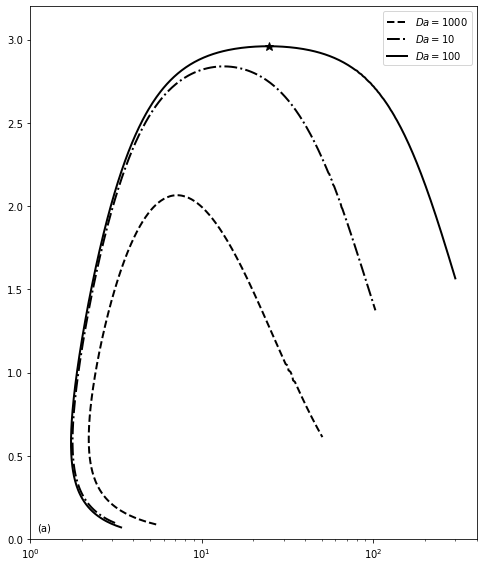

In [9]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

ax.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax.set_xscale('log')
ax.set_xlim(1.0, 400.0)
ax.set_xticks((1e0, 1e1, 1e2))
ax.set_ylim(0.0, 3.2)
ax.text(1.1, 0.1, '(a)', verticalalignment='top', horizontalalignment='left')
plt.legend()
plt.show()

In [10]:
DC_ref.k[iref], DC_ref.s[iref]

(24.655561068701545, 2.9598758196773103)

In [11]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


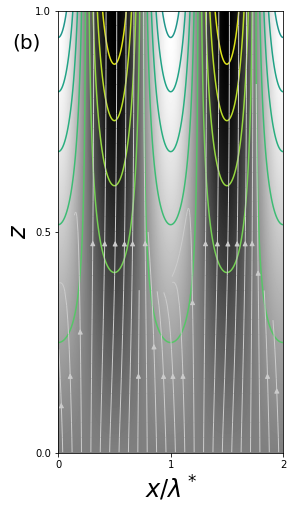

In [16]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.06 * zoom)
f.set_facecolor('w')

plt.imshow(np.flipud(P), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
cs = plt.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
# plt.clabel(cs, linewidth=1.5)

nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
plt.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
plt.xlabel(r'$x/\lambda^*$', fontsize=24)
plt.xlim(0, 2.*lambda_)
plt.xticks(ticks=(0, lambda_, 2*lambda_), labels=(0, 1, 2))
plt.ylabel(r'$z$', fontsize=24)
plt.ylim(0, 1)
plt.yticks((0, 0.5, 1))
plt.text(-0.04, 0.95, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')
plt.show()

### The large-Damkohler number limit

In [24]:
Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])
DC_cube = {}
DC_quad = {}

for vals in [10., 100., 1000.]:
    par = PAR(Da_=vals, largeDa_=False)
    DC_cube[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

    par = PAR(Da_=vals, largeDa_=True)
    DC_quad[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=1.9700163558867765
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=1.9570167816517678
Iteration 2: searching for solution at k=4.818066292998758
SUCCESS: monotonic eigenfunction for k=4.818066292998758, sigma=1.9486469892766827
Iteration 3: searching for solution at k=4.754040003771168
SUCCESS: monotonic eigenfunction for k=4.754040003771168, sigma=1.9403553170435563
Iteration 4: searching for solution at k=4.692426291378214
SUCCESS: monotonic eigenfunction for k=4.692426291378214, sigma=1.9319700450992363
Iteration 5: searching for solution at k=4.633064371552892
SUCCESS: monotonic eigenfunction for k=4.633064371552892, sigma=1.9234983480123409
Iteration 6: searching for solution at k=4.5758148172813105
SUCCESS: monotonic eigenfunction for k=4.5758148172813105, sigma=1.9149475845022907
Iteration 7: searching for solution at k=4.520549371340002
SUCC

SUCCESS: monotonic eigenfunction for k=2.9207714252179886, sigma=1.3987133986216935
Iteration 62: searching for solution at k=2.9039132773538574
SUCCESS: monotonic eigenfunction for k=2.9039132773538574, sigma=1.388986553341307
Iteration 63: searching for solution at k=2.8873073341723305
SUCCESS: monotonic eigenfunction for k=2.8873073341723305, sigma=1.3792538595402484
Iteration 64: searching for solution at k=2.87094845215095
SUCCESS: monotonic eigenfunction for k=2.87094845215095, sigma=1.3695154234075526
Iteration 65: searching for solution at k=2.8548316993555907
SUCCESS: monotonic eigenfunction for k=2.8548316993555907, sigma=1.3597713443328892
Iteration 66: searching for solution at k=2.838952347286206
SUCCESS: monotonic eigenfunction for k=2.838952347286206, sigma=1.3500217151417906
Iteration 67: searching for solution at k=2.823305863236351
SUCCESS: monotonic eigenfunction for k=2.823305863236351, sigma=1.340266622309983
Iteration 68: searching for solution at k=2.807887903136

SUCCESS: monotonic eigenfunction for k=2.2750241875037345, sigma=0.8356673069826155
Iteration 119: searching for solution at k=2.2688289776978223
SUCCESS: monotonic eigenfunction for k=2.2688289776978223, sigma=0.8255845156693287
Iteration 120: searching for solution at k=2.262830559937383
SUCCESS: monotonic eigenfunction for k=2.262830559937383, sigma=0.8154880522816933
Iteration 121: searching for solution at k=2.2570328473925887
SUCCESS: monotonic eigenfunction for k=2.2570328473925887, sigma=0.8053768183471879
Iteration 122: searching for solution at k=2.2514400744614735
SUCCESS: monotonic eigenfunction for k=2.2514400744614735, sigma=0.7952495356617809
Iteration 123: searching for solution at k=2.2460568201002693
SUCCESS: monotonic eigenfunction for k=2.2460568201002693, sigma=0.785104703985472
Iteration 124: searching for solution at k=2.2408880341772797
SUCCESS: monotonic eigenfunction for k=2.2408880341772797, sigma=0.7749405454125572
Iteration 125: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=2.548012128590511, sigma=0.2942982849305799
Iteration 175: searching for solution at k=2.57787067466124
SUCCESS: monotonic eigenfunction for k=2.57787067466124, sigma=0.28593205922280407
Iteration 176: searching for solution at k=2.6094951330141503
SUCCESS: monotonic eigenfunction for k=2.6094951330141503, sigma=0.2777004236221228
Iteration 177: searching for solution at k=2.6429375827710544
SUCCESS: monotonic eigenfunction for k=2.6429375827710544, sigma=0.2696119153031543
Iteration 178: searching for solution at k=2.678246569762177
SUCCESS: monotonic eigenfunction for k=2.678246569762177, sigma=0.26167470340916216
Iteration 179: searching for solution at k=2.7154667569675945
SUCCESS: monotonic eigenfunction for k=2.7154667569675945, sigma=0.2538964612624246
Iteration 180: searching for solution at k=2.754638689963233
SUCCESS: monotonic eigenfunction for k=2.754638689963233, sigma=0.24628424430285917
Iteration 181: searching for solution at k=2.7

FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at k=5.546725500733714
FAILURE: no solution found for k=5.546725500733714
Iteration 215: searching for solution at sigma=0.08496030370179808
FAILURE: non-monotonic eigenfunction for k=6.462907396995104, sigma=0.08496030370179808
Iteration 215: searching for solution at k=5.071604746902777
SUCCESS: monotonic eigenfunction for k=5.071604746902777, sigma=1.977597708193289
Iteration 216: searching for solution at k=5.146882718933767
SUCCESS: monotonic eigenfunction for k=5.146882718933767, sigma=1.9850979474381596
Iteration 217: searching for solution at k=5.225450712377876
SUCCESS: monotonic eigenfunction for k=5.225450712377876, sigma=1.9924362645650278
Iteration 218: searching for solution at k=5.307540535674139
SUCCESS: monotonic eigenfunction for k=5.307540535674139, sigma=1.9995950848331292
Iteration 219: searching for solution at k=5.393405914221006
SUCCESS: monotonic eigenfunction for k=5.39340

SUCCESS: monotonic eigenfunction for k=13.349302787542149, sigma=1.8310970745717727
Iteration 271: searching for solution at k=13.510988387902303
SUCCESS: monotonic eigenfunction for k=13.510988387902303, sigma=1.8225101687856904
Iteration 272: searching for solution at k=13.672850422871816
SUCCESS: monotonic eigenfunction for k=13.672850422871816, sigma=1.813891016386869
Iteration 273: searching for solution at k=13.834924010611173
SUCCESS: monotonic eigenfunction for k=13.834924010611173, sigma=1.8052414378762875
Iteration 274: searching for solution at k=13.99724324120161
SUCCESS: monotonic eigenfunction for k=13.99724324120161, sigma=1.7965631208723598
Iteration 275: searching for solution at k=14.159841252078595
SUCCESS: monotonic eigenfunction for k=14.159841252078595, sigma=1.7878576325320485
Iteration 276: searching for solution at k=14.32275029949728
SUCCESS: monotonic eigenfunction for k=14.32275029949728, sigma=1.7791264306003756
Iteration 277: searching for solution at k=14

SUCCESS: monotonic eigenfunction for k=24.33405800336815, sigma=1.2897256940489181
Iteration 331: searching for solution at k=24.55577052501783
SUCCESS: monotonic eigenfunction for k=24.55577052501783, sigma=1.2805312681990066
Iteration 332: searching for solution at k=24.779371919787803
SUCCESS: monotonic eigenfunction for k=24.779371919787803, sigma=1.2713363917410707
Iteration 333: searching for solution at k=25.00489942439648
SUCCESS: monotonic eigenfunction for k=25.00489942439648, sigma=1.2621412280363138
Iteration 334: searching for solution at k=25.23239099851742
SUCCESS: monotonic eigenfunction for k=25.23239099851742, sigma=1.2529459389467634
Iteration 335: searching for solution at k=25.46188535008186
SUCCESS: monotonic eigenfunction for k=25.46188535008186, sigma=1.2437506850060127
Iteration 336: searching for solution at k=25.69342196127764
SUCCESS: monotonic eigenfunction for k=25.69342196127764, sigma=1.234555625585348
Iteration 337: searching for solution at k=25.927041

FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at k=36.5065355594549
FAILURE: no solution found for k=36.5065355594549
Iteration 370: searching for solution at sigma=0.8995954466887126
SUCCESS: monotonic eigenfunction for k=36.50736679182216, sigma=0.8995954466887126
Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259
Iteration 371: searching for solution at k=36.84968816790259
FAILURE: no solution found for k=36.84968816790259
Iteration 371: searching for solution at sigma=0.890453733021462
SUCCESS: monotonic eigenfunction for k=36.85054885168643, sigma=0.890453733021462
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at sigma=0.8813194555832876
SUCCESS: monotonic eigenfu

FAILURE: no solution found for k=45.32879540969027
Iteration 392: searching for solution at k=45.32879540969027
FAILURE: no solution found for k=45.32879540969027
Iteration 392: searching for solution at sigma=0.7005813897017005
SUCCESS: monotonic eigenfunction for k=45.33058859537991, sigma=0.7005813897017005
Iteration 393: searching for solution at k=45.805605413512325
FAILURE: no solution found for k=45.805605413512325
Iteration 393: searching for solution at k=45.805605413512325
FAILURE: no solution found for k=45.805605413512325
Iteration 393: searching for solution at sigma=0.691664859926009
SUCCESS: monotonic eigenfunction for k=45.807463996506954, sigma=0.691664859926009
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at sigma=0.6827624130273926
SUCCESS: monotonic

SUCCESS: monotonic eigenfunction for k=3.410507592236223, sigma=1.9283921433753701
Iteration 29: searching for solution at k=3.3781081309674574
SUCCESS: monotonic eigenfunction for k=3.3781081309674574, sigma=1.9192006848414007
Iteration 30: searching for solution at k=3.3465492383899353
SUCCESS: monotonic eigenfunction for k=3.3465492383899353, sigma=1.9099803438215688
Iteration 31: searching for solution at k=3.3157927850429023
SUCCESS: monotonic eigenfunction for k=3.3157927850429023, sigma=1.9007327837911234
Iteration 32: searching for solution at k=3.285803166552678
SUCCESS: monotonic eigenfunction for k=3.285803166552678, sigma=1.891459532062629
Iteration 33: searching for solution at k=3.256547092103185
SUCCESS: monotonic eigenfunction for k=3.256547092103185, sigma=1.8821619935541305
Iteration 34: searching for solution at k=3.227993394106238
SUCCESS: monotonic eigenfunction for k=3.227993394106238, sigma=1.8728414628971317
Iteration 35: searching for solution at k=3.2001128566

SUCCESS: monotonic eigenfunction for k=2.284567016890482, sigma=1.351625740509437
Iteration 89: searching for solution at k=2.273950544739756
SUCCESS: monotonic eigenfunction for k=2.273950544739756, sigma=1.3417709517992282
Iteration 90: searching for solution at k=2.263508790882354
SUCCESS: monotonic eigenfunction for k=2.263508790882354, sigma=1.3319102118813677
Iteration 91: searching for solution at k=2.2532403332734643
SUCCESS: monotonic eigenfunction for k=2.2532403332734643, sigma=1.3220434786837365
Iteration 92: searching for solution at k=2.2431438831767854
SUCCESS: monotonic eigenfunction for k=2.2431438831767854, sigma=1.312170701635889
Iteration 93: searching for solution at k=2.2332182848640403
SUCCESS: monotonic eigenfunction for k=2.2332182848640403, sigma=1.302291821296907
Iteration 94: searching for solution at k=2.2234625156275487
SUCCESS: monotonic eigenfunction for k=2.2234625156275487, sigma=1.292406768925367
Iteration 95: searching for solution at k=2.21387568611

SUCCESS: monotonic eigenfunction for k=1.9815696717775102, sigma=0.8015476636321752
Iteration 144: searching for solution at k=1.983346988317297
SUCCESS: monotonic eigenfunction for k=1.983346988317297, sigma=0.7924966020809151
Iteration 145: searching for solution at k=1.9855318366155597
SUCCESS: monotonic eigenfunction for k=1.9855318366155597, sigma=0.7833412616460429
Iteration 146: searching for solution at k=1.9881482479710182
SUCCESS: monotonic eigenfunction for k=1.9881482479710182, sigma=0.7741073008412298
Iteration 147: searching for solution at k=1.9912206463764766
SUCCESS: monotonic eigenfunction for k=1.9912206463764766, sigma=0.7648133558239031
Iteration 148: searching for solution at k=1.9947742690121422
SUCCESS: monotonic eigenfunction for k=1.9947742690121422, sigma=0.75547347695336
Iteration 149: searching for solution at k=1.9988354503607246
SUCCESS: monotonic eigenfunction for k=1.9988354503607246, sigma=0.746098693226321
Iteration 150: searching for solution at k=2.

FAILURE: no solution found for k=4.414229514690119
Iteration 206: searching for solution at k=4.414229514690119
FAILURE: no solution found for k=4.414229514690119
Iteration 206: searching for solution at sigma=0.36293588267813404
SUCCESS: monotonic eigenfunction for k=4.416317729150877, sigma=0.36293588267813404
Iteration 207: searching for solution at k=4.5160952391686235
SUCCESS: monotonic eigenfunction for k=4.5160952391686235, sigma=0.3605635658432542
Iteration 208: searching for solution at k=4.6183736245962725
SUCCESS: monotonic eigenfunction for k=4.6183736245962725, sigma=0.35828238901963017
Iteration 209: searching for solution at k=4.7231945543781695
SUCCESS: monotonic eigenfunction for k=4.7231945543781695, sigma=0.35608745699725924
Iteration 210: searching for solution at k=4.830604474406305
SUCCESS: monotonic eigenfunction for k=4.830604474406305, sigma=0.35397397644267015
Iteration 211: searching for solution at k=4.940651694868074
SUCCESS: monotonic eigenfunction for k=4

SUCCESS: monotonic eigenfunction for k=5.553018208558282, sigma=2.174176715746555
Iteration 239: searching for solution at k=5.679902136014598
SUCCESS: monotonic eigenfunction for k=5.679902136014598, sigma=2.1757948515202674
Iteration 240: searching for solution at k=5.8114964408607905
SUCCESS: monotonic eigenfunction for k=5.8114964408607905, sigma=2.1766040134866467
Iteration 241: searching for solution at k=5.947102466215265
SUCCESS: monotonic eigenfunction for k=5.947102466215265, sigma=2.1765767961676517
Iteration 242: searching for solution at k=6.085858204268639
SUCCESS: monotonic eigenfunction for k=6.085858204268639, sigma=2.1757081346797187
Iteration 243: searching for solution at k=6.226812992312336
SUCCESS: monotonic eigenfunction for k=6.226812992312336, sigma=2.1740166166288115
Iteration 244: searching for solution at k=6.369017860199212
SUCCESS: monotonic eigenfunction for k=6.369017860199212, sigma=2.1715422193656244
Iteration 245: searching for solution at k=6.5116080

SUCCESS: monotonic eigenfunction for k=12.412687901328567, sigma=1.76152729546793
Iteration 296: searching for solution at k=12.524505267297258
SUCCESS: monotonic eigenfunction for k=12.524505267297258, sigma=1.7522841475683193
Iteration 297: searching for solution at k=12.63663345686012
SUCCESS: monotonic eigenfunction for k=12.63663345686012, sigma=1.7430322252914074
Iteration 298: searching for solution at k=12.749094079025088
SUCCESS: monotonic eigenfunction for k=12.749094079025088, sigma=1.7337720109590502
Iteration 299: searching for solution at k=12.861908560585432
SUCCESS: monotonic eigenfunction for k=12.861908560585432, sigma=1.724503963176012
Iteration 300: searching for solution at k=12.975098176484222
SUCCESS: monotonic eigenfunction for k=12.975098176484222, sigma=1.7152285185990002
Iteration 301: searching for solution at k=13.088684078810687
SUCCESS: monotonic eigenfunction for k=13.088684078810687, sigma=1.7059460935577264
Iteration 302: searching for solution at k=13

SUCCESS: monotonic eigenfunction for k=20.454307604521446, sigma=1.2018664393604694
Iteration 356: searching for solution at k=20.6283751611708
SUCCESS: monotonic eigenfunction for k=20.6283751611708, sigma=1.19258726394003
Iteration 357: searching for solution at k=20.804536121841622
SUCCESS: monotonic eigenfunction for k=20.804536121841622, sigma=1.1833138648033208
Iteration 358: searching for solution at k=20.982844186227464
SUCCESS: monotonic eigenfunction for k=20.982844186227464, sigma=1.174046471717023
Iteration 359: searching for solution at k=21.163354561365974
SUCCESS: monotonic eigenfunction for k=21.163354561365974, sigma=1.1647853187673218
Iteration 360: searching for solution at k=21.346124012614965
SUCCESS: monotonic eigenfunction for k=21.346124012614965, sigma=1.1555306445526932
Iteration 361: searching for solution at k=21.53121091596592
SUCCESS: monotonic eigenfunction for k=21.53121091596592, sigma=1.1462826923764091
Iteration 362: searching for solution at k=21.718

SUCCESS: monotonic eigenfunction for k=36.129893960054076, sigma=0.6911989428930211
Iteration 413: searching for solution at k=36.576154614526715
FAILURE: no solution found for k=36.576154614526715
Iteration 413: searching for solution at k=36.576154614526715
FAILURE: no solution found for k=36.576154614526715
Iteration 413: searching for solution at sigma=0.6827385315439145
SUCCESS: monotonic eigenfunction for k=36.57872046221186, sigma=0.6827385315439145
Iteration 414: searching for solution at k=37.03422285967173
SUCCESS: monotonic eigenfunction for k=37.03422285967173, sigma=0.6743535582891388
Iteration 415: searching for solution at k=37.499152270517556
SUCCESS: monotonic eigenfunction for k=37.499152270517556, sigma=0.6659960415999451
Iteration 416: searching for solution at k=37.97371739228771
SUCCESS: monotonic eigenfunction for k=37.97371739228771, sigma=0.6576665132339
Iteration 417: searching for solution at k=38.45814012435055
SUCCESS: monotonic eigenfunction for k=38.45814

SUCCESS: monotonic eigenfunction for k=3.789503295585066, sigma=2.2949489147570956
Iteration 28: searching for solution at k=3.7584092895594616
SUCCESS: monotonic eigenfunction for k=3.7584092895594616, sigma=2.2855533131114893
Iteration 29: searching for solution at k=3.7279019254629886
SUCCESS: monotonic eigenfunction for k=3.7279019254629886, sigma=2.276143813621912
Iteration 30: searching for solution at k=3.697963433577498
SUCCESS: monotonic eigenfunction for k=3.697963433577498, sigma=2.266720914940597
Iteration 31: searching for solution at k=3.6685767530563984
SUCCESS: monotonic eigenfunction for k=3.6685767530563984, sigma=2.25728509284874
Iteration 32: searching for solution at k=3.6397254985421132
SUCCESS: monotonic eigenfunction for k=3.6397254985421132, sigma=2.247836801471999
Iteration 33: searching for solution at k=3.611393928526781
SUCCESS: monotonic eigenfunction for k=3.611393928526781, sigma=2.238376474424053
Iteration 34: searching for solution at k=3.5835669153630

SUCCESS: monotonic eigenfunction for k=2.591463146906145, sigma=1.7265446335495005
Iteration 87: searching for solution at k=2.5781780159600043
SUCCESS: monotonic eigenfunction for k=2.5781780159600043, sigma=1.7167659580603998
Iteration 88: searching for solution at k=2.5650406169283757
SUCCESS: monotonic eigenfunction for k=2.5650406169283757, sigma=1.7069843814679928
Iteration 89: searching for solution at k=2.552048473938618
SUCCESS: monotonic eigenfunction for k=2.552048473938618, sigma=1.6971999502054438
Iteration 90: searching for solution at k=2.53919918121837
SUCCESS: monotonic eigenfunction for k=2.53919918121837, sigma=1.6874127088033564
Iteration 91: searching for solution at k=2.5264904010838167
SUCCESS: monotonic eigenfunction for k=2.5264904010838167, sigma=1.6776226999372001
Iteration 92: searching for solution at k=2.5139198620126995
SUCCESS: monotonic eigenfunction for k=2.5139198620126995, sigma=1.6678299644719607
Iteration 93: searching for solution at k=2.501485356

SUCCESS: monotonic eigenfunction for k=1.9905881130712657, sigma=1.1255653306752231
Iteration 148: searching for solution at k=1.983635246947993
SUCCESS: monotonic eigenfunction for k=1.983635246947993, sigma=1.115636872386431
Iteration 149: searching for solution at k=1.9767666982721095
SUCCESS: monotonic eigenfunction for k=1.9767666982721095, sigma=1.105705317344363
Iteration 150: searching for solution at k=1.9699826564506784
SUCCESS: monotonic eigenfunction for k=1.9699826564506784, sigma=1.0957705903358144
Iteration 151: searching for solution at k=1.9632833575738036
SUCCESS: monotonic eigenfunction for k=1.9632833575738036, sigma=1.0858326112681085
Iteration 152: searching for solution at k=1.9566690857493185
SUCCESS: monotonic eigenfunction for k=1.9566690857493185, sigma=1.075891294828822
Iteration 153: searching for solution at k=1.9501401745392162
SUCCESS: monotonic eigenfunction for k=1.9501401745392162, sigma=1.065946550109773
Iteration 154: searching for solution at k=1.9

SUCCESS: monotonic eigenfunction for k=1.7652683242419032, sigma=0.5750775706527872
Iteration 202: searching for solution at k=1.7655211451094568
SUCCESS: monotonic eigenfunction for k=1.7655211451094568, sigma=0.5679053564647218
Iteration 203: searching for solution at k=1.7660057141151593
SUCCESS: monotonic eigenfunction for k=1.7660057141151593, sigma=0.5593707219445556
Iteration 204: searching for solution at k=1.766710633697393
SUCCESS: monotonic eigenfunction for k=1.766710633697393, sigma=0.5506938094268817
Iteration 205: searching for solution at k=1.7676652714851473
SUCCESS: monotonic eigenfunction for k=1.7676652714851473, sigma=0.5417919834397531
Iteration 206: searching for solution at k=1.7688855843381146
SUCCESS: monotonic eigenfunction for k=1.7688855843381146, sigma=0.5327464654959326
Iteration 207: searching for solution at k=1.7703885980934486
SUCCESS: monotonic eigenfunction for k=1.7703885980934486, sigma=0.5235927917298769
Iteration 208: searching for solution at k

SUCCESS: monotonic eigenfunction for k=2.9916904597566614, sigma=0.1047013518613611
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at k=3.054621698847048
FAILURE: no solution found for k=3.054621698847048
Iteration 260: searching for solution at sigma=0.10042368947553852
SUCCESS: monotonic eigenfunction for k=3.0563327882354674, sigma=0.10042368947553852
Iteration 261: searching for solution at k=3.1212350287100166
FAILURE: no solution found for k=3.1212350287100166
Iteration 261: searching for solution at k=3.1212350287100166
FAILURE: no solution found for k=3.1212350287100166
Iteration 261: searching for solution at sigma=0.09633092641167457
SUCCESS: monotonic eigenfunction for k=3.1229818338022053, sigma=0.09633092641167457
Iteration 262: searching for solution at k=3.1898705959607465
FAILURE: no solution found for k=3.1898705959607465
Iteration 262: searching for solution at k=3.1

SUCCESS: monotonic eigenfunction for k=13.229750326992974, sigma=2.838893271551917
Iteration 316: searching for solution at k=13.53795048893754
SUCCESS: monotonic eigenfunction for k=13.53795048893754, sigma=2.8389109306019584
Iteration 317: searching for solution at k=13.853344176496924
SUCCESS: monotonic eigenfunction for k=13.853344176496924, sigma=2.8386835442039953
Iteration 318: searching for solution at k=14.17590379556414
SUCCESS: monotonic eigenfunction for k=14.17590379556414, sigma=2.8382112653795812
Iteration 319: searching for solution at k=14.505587991812165
SUCCESS: monotonic eigenfunction for k=14.505587991812165, sigma=2.8374944222422163
Iteration 320: searching for solution at k=14.842341002724753
SUCCESS: monotonic eigenfunction for k=14.842341002724753, sigma=2.836533523939592
Iteration 321: searching for solution at k=15.186092064560007
SUCCESS: monotonic eigenfunction for k=15.186092064560007, sigma=2.8353292694379393
Iteration 322: searching for solution at k=15.

SUCCESS: monotonic eigenfunction for k=38.06664517771929, sigma=2.525137097594407
Iteration 374: searching for solution at k=38.52789919480171
SUCCESS: monotonic eigenfunction for k=38.52789919480171, sigma=2.516541222977684
Iteration 375: searching for solution at k=38.98888476276779
SUCCESS: monotonic eigenfunction for k=38.98888476276779, sigma=2.507907061096877
Iteration 376: searching for solution at k=39.449618604720584
SUCCESS: monotonic eigenfunction for k=39.449618604720584, sigma=2.499236303759834
Iteration 377: searching for solution at k=39.910119395488984
SUCCESS: monotonic eigenfunction for k=39.910119395488984, sigma=2.490530556326049
Iteration 378: searching for solution at k=40.37040756671438
SUCCESS: monotonic eigenfunction for k=40.37040756671438, sigma=2.481791342335621
Iteration 379: searching for solution at k=40.83050512876608
SUCCESS: monotonic eigenfunction for k=40.83050512876608, sigma=2.4730201079285914
Iteration 380: searching for solution at k=41.290435508

FAILURE: no solution found for k=60.913542687044064
Iteration 419: searching for solution at sigma=2.0829053281388448
SUCCESS: monotonic eigenfunction for k=60.91219017651378, sigma=2.0829053281388448
Iteration 420: searching for solution at k=61.390106802314925
FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at k=61.390106802314925
FAILURE: no solution found for k=61.390106802314925
Iteration 420: searching for solution at sigma=2.0734989554815155
SUCCESS: monotonic eigenfunction for k=61.38877865982986, sigma=2.0734989554815155
Iteration 421: searching for solution at k=61.86803186818622
FAILURE: no solution found for k=61.86803186818622
Iteration 421: searching for solution at k=61.86803186818622
FAILURE: no solution found for k=61.86803186818622
Iteration 421: searching for solution at sigma=2.064086514681437
SUCCESS: monotonic eigenfunction for k=61.8667284102018, sigma=2.064086514681437
Iteration 422: searching for solution at k=62.347351

FAILURE: no solution found for k=72.54199630676911
Iteration 442: searching for solution at sigma=1.8604915364888979
SUCCESS: monotonic eigenfunction for k=72.54116805980577, sigma=1.8604915364888979
Iteration 443: searching for solution at k=73.05994165616211
FAILURE: no solution found for k=73.05994165616211
Iteration 443: searching for solution at k=73.05994165616211
FAILURE: no solution found for k=73.05994165616211
Iteration 443: searching for solution at sigma=1.8509824656590854
SUCCESS: monotonic eigenfunction for k=73.05913389330449, sigma=1.8509824656590854
Iteration 444: searching for solution at k=73.58011557729147
FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at k=73.58011557729147
FAILURE: no solution found for k=73.58011557729147
Iteration 444: searching for solution at sigma=1.841470525667981
SUCCESS: monotonic eigenfunction for k=73.57932823447386, sigma=1.841470525667981
Iteration 445: searching for solution at k=74.1025598765

FAILURE: no solution found for k=85.09769150567634
Iteration 465: searching for solution at sigma=1.6412158589557126
SUCCESS: monotonic eigenfunction for k=85.09733484684381, sigma=1.6412158589557126
Iteration 466: searching for solution at k=85.67852587486676
FAILURE: no solution found for k=85.67852587486676
Iteration 466: searching for solution at k=85.67852587486676
FAILURE: no solution found for k=85.67852587486676
Iteration 466: searching for solution at sigma=1.631662748756295
SUCCESS: monotonic eigenfunction for k=85.67819061945245, sigma=1.631662748756295
Iteration 467: searching for solution at k=86.26271050436453
FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at k=86.26271050436453
FAILURE: no solution found for k=86.26271050436453
Iteration 467: searching for solution at sigma=1.622108644959938
SUCCESS: monotonic eigenfunction for k=86.26239681033871, sigma=1.622108644959938
Iteration 468: searching for solution at k=86.850303594790

SUCCESS: monotonic eigenfunction for k=98.74771802192944, sigma=1.4309207448008872
Iteration 488: searching for solution at k=99.41726845196764
FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at k=99.41726845196764
FAILURE: no solution found for k=99.41726845196764
Iteration 488: searching for solution at sigma=1.4213610797889404
SUCCESS: monotonic eigenfunction for k=99.41746508563529, sigma=1.4213610797889404
Iteration 489: searching for solution at k=100.09189409129961
FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at k=100.09189409129961
FAILURE: no solution found for k=100.09189409129961
Iteration 489: searching for solution at sigma=1.4118018643231545
SUCCESS: monotonic eigenfunction for k=100.09211891563753, sigma=1.4118018643231545
Iteration 490: searching for solution at k=100.77151365557371
FAILURE: no solution found for k=100.77151365557371
Iteration 490: searching for solution at k=100.77151

SUCCESS: monotonic eigenfunction for k=3.353680913717292, sigma=2.16933212724802
Iteration 43: searching for solution at k=3.3296245304117797
SUCCESS: monotonic eigenfunction for k=3.3296245304117797, sigma=2.1597853311740773
Iteration 44: searching for solution at k=3.3059585800685034
SUCCESS: monotonic eigenfunction for k=3.3059585800685034, sigma=2.150229764184244
Iteration 45: searching for solution at k=3.2826727235430826
SUCCESS: monotonic eigenfunction for k=3.2826727235430826, sigma=2.1406656987620907
Iteration 46: searching for solution at k=3.259756993588403
SUCCESS: monotonic eigenfunction for k=3.259756993588403, sigma=2.131093396100046
Iteration 47: searching for solution at k=3.2372017787891125
SUCCESS: monotonic eigenfunction for k=3.2372017787891125, sigma=2.1215131066425674
Iteration 48: searching for solution at k=3.2149978082977086
SUCCESS: monotonic eigenfunction for k=3.2149978082977086, sigma=2.1119250705990593
Iteration 49: searching for solution at k=3.193136137

FAILURE: no solution found for k=2.369207263246682
Iteration 102: searching for solution at k=2.369207263246682
FAILURE: no solution found for k=2.369207263246682
Iteration 102: searching for solution at sigma=1.5867894385189933
SUCCESS: monotonic eigenfunction for k=2.3692410354578746, sigma=1.5867894385189933
Iteration 103: searching for solution at k=2.3580866098195283
SUCCESS: monotonic eigenfunction for k=2.3580866098195283, sigma=1.5769722798779855
Iteration 104: searching for solution at k=2.3470484869407717
SUCCESS: monotonic eigenfunction for k=2.3470484869407717, sigma=1.5671526054045617
Iteration 105: searching for solution at k=2.336125178182914
FAILURE: no solution found for k=2.336125178182914
Iteration 105: searching for solution at k=2.336125178182914
FAILURE: no solution found for k=2.336125178182914
Iteration 105: searching for solution at sigma=1.557359974053878
SUCCESS: monotonic eigenfunction for k=2.336157757786526, sigma=1.557359974053878
Iteration 106: searching

SUCCESS: monotonic eigenfunction for k=1.9261191995666338, sigma=1.0831685276686447
Iteration 154: searching for solution at k=1.9197205760324736
SUCCESS: monotonic eigenfunction for k=1.9197205760324736, sigma=1.0732209933169135
Iteration 155: searching for solution at k=1.9134081516659498
SUCCESS: monotonic eigenfunction for k=1.9134081516659498, sigma=1.0632697771941733
Iteration 156: searching for solution at k=1.9071824112936562
SUCCESS: monotonic eigenfunction for k=1.9071824112936562, sigma=1.05331476772608
Iteration 157: searching for solution at k=1.9010438963306948
SUCCESS: monotonic eigenfunction for k=1.9010438963306948, sigma=1.0433558456581609
Iteration 158: searching for solution at k=1.8949932068316908
SUCCESS: monotonic eigenfunction for k=1.8949932068316908, sigma=1.0333928834026342
Iteration 159: searching for solution at k=1.8890310036915483
SUCCESS: monotonic eigenfunction for k=1.8890310036915483, sigma=1.0234257443055583
Iteration 160: searching for solution at k

SUCCESS: monotonic eigenfunction for k=1.7567523448819493, sigma=0.5076647928135113
Iteration 212: searching for solution at k=1.7598016087661863
SUCCESS: monotonic eigenfunction for k=1.7598016087661863, sigma=0.49825323974253916
Iteration 213: searching for solution at k=1.763232174012174
SUCCESS: monotonic eigenfunction for k=1.763232174012174, sigma=0.4888163152412395
Iteration 214: searching for solution at k=1.7670644366324342
SUCCESS: monotonic eigenfunction for k=1.7670644366324342, sigma=0.4793601781231641
Iteration 215: searching for solution at k=1.7713199643958306
SUCCESS: monotonic eigenfunction for k=1.7713199643958306, sigma=0.46989018061494225
Iteration 216: searching for solution at k=1.7760215996914637
SUCCESS: monotonic eigenfunction for k=1.7760215996914637, sigma=0.46041111521434774
Iteration 217: searching for solution at k=1.7811935581823293
SUCCESS: monotonic eigenfunction for k=1.7811935581823293, sigma=0.4509273975826503
Iteration 218: searching for solution a

SUCCESS: monotonic eigenfunction for k=3.560629349027247, sigma=0.09252784328108456
Iteration 269: searching for solution at k=3.639980511897519
SUCCESS: monotonic eigenfunction for k=3.639980511897519, sigma=0.08970061202289975
Iteration 270: searching for solution at k=3.7214284874035144
SUCCESS: monotonic eigenfunction for k=3.7214284874035144, sigma=0.0870000679482951
Iteration 271: searching for solution at k=3.8050048443166062
SUCCESS: monotonic eigenfunction for k=3.8050048443166062, sigma=0.08442086767832437
Iteration 272: searching for solution at k=3.8907430390215403
SUCCESS: monotonic eigenfunction for k=3.8907430390215403, sigma=0.08195782510334053
Iteration 273: searching for solution at k=3.978678397563856
SUCCESS: monotonic eigenfunction for k=3.978678397563856, sigma=0.07960591911650712
Iteration 274: searching for solution at k=4.068848096915883
SUCCESS: monotonic eigenfunction for k=4.068848096915883, sigma=0.07736029864902354
Iteration 275: searching for solution at 

SUCCESS: monotonic eigenfunction for k=7.811330288689618, sigma=2.773151115741586
Iteration 322: searching for solution at k=7.963687727903893
SUCCESS: monotonic eigenfunction for k=7.963687727903893, sigma=2.7784695892240574
Iteration 323: searching for solution at k=8.121162084986603
SUCCESS: monotonic eigenfunction for k=8.121162084986603, sigma=2.7836069179443754
Iteration 324: searching for solution at k=8.28389753922698
SUCCESS: monotonic eigenfunction for k=8.28389753922698, sigma=2.788557817854067
Iteration 325: searching for solution at k=8.452036021657866
SUCCESS: monotonic eigenfunction for k=8.452036021657866, sigma=2.793317163429625
Iteration 326: searching for solution at k=8.625716692014954
SUCCESS: monotonic eigenfunction for k=8.625716692014954, sigma=2.7978800152423515
Iteration 327: searching for solution at k=8.805075437559774
SUCCESS: monotonic eigenfunction for k=8.805075437559774, sigma=2.8022416454493766
Iteration 328: searching for solution at k=8.9902443993014

SUCCESS: monotonic eigenfunction for k=27.192415184669184, sigma=2.7102705463561083
Iteration 381: searching for solution at k=27.651713647427737
SUCCESS: monotonic eigenfunction for k=27.651713647427737, sigma=2.7032971611134293
Iteration 382: searching for solution at k=28.11160323831555
SUCCESS: monotonic eigenfunction for k=28.11160323831555, sigma=2.6962099502144934
Iteration 383: searching for solution at k=28.571952416992925
SUCCESS: monotonic eigenfunction for k=28.571952416992925, sigma=2.689013988006827
Iteration 384: searching for solution at k=29.03264151933473
SUCCESS: monotonic eigenfunction for k=29.03264151933473, sigma=2.6817141858785063
Iteration 385: searching for solution at k=29.493562358077106
SUCCESS: monotonic eigenfunction for k=29.493562358077106, sigma=2.6743152854648398
Iteration 386: searching for solution at k=29.9546177629081
SUCCESS: monotonic eigenfunction for k=29.9546177629081, sigma=2.6668218539730777
Iteration 387: searching for solution at k=30.415

SUCCESS: monotonic eigenfunction for k=54.646716238419664, sigma=2.1938079642256643
Iteration 441: searching for solution at k=55.110960104247944
SUCCESS: monotonic eigenfunction for k=55.110960104247944, sigma=2.1844724796693433
Iteration 442: searching for solution at k=55.57607516080302
SUCCESS: monotonic eigenfunction for k=55.57607516080302, sigma=2.1751281240066445
Iteration 443: searching for solution at k=56.042091063979086
FAILURE: no solution found for k=56.042091063979086
Iteration 443: searching for solution at k=56.042091063979086
FAILURE: no solution found for k=56.042091063979086
Iteration 443: searching for solution at sigma=2.1658088275532075
SUCCESS: monotonic eigenfunction for k=56.04042052464342, sigma=2.1658088275532075
Iteration 444: searching for solution at k=56.50736431465037
SUCCESS: monotonic eigenfunction for k=56.50736431465037, sigma=2.156447995813032
Iteration 445: searching for solution at k=56.975285543451676
SUCCESS: monotonic eigenfunction for k=56.97

SUCCESS: monotonic eigenfunction for k=3.731475589025499, sigma=2.3232672157988254
Iteration 30: searching for solution at k=3.7014923805768984
SUCCESS: monotonic eigenfunction for k=3.7014923805768984, sigma=2.313845770033832
Iteration 31: searching for solution at k=3.6720576731701895
SUCCESS: monotonic eigenfunction for k=3.6720576731701895, sigma=2.3044115333143
Iteration 32: searching for solution at k=3.643155440639268
SUCCESS: monotonic eigenfunction for k=3.643155440639268, sigma=2.2949649457474752
Iteration 33: searching for solution at k=3.6147702687796746
SUCCESS: monotonic eigenfunction for k=3.6147702687796746, sigma=2.2855064282694544
Iteration 34: searching for solution at k=3.5868873280586535
SUCCESS: monotonic eigenfunction for k=3.5868873280586535, sigma=2.2760363835992945
Iteration 35: searching for solution at k=3.5594923476512665
SUCCESS: monotonic eigenfunction for k=3.5594923476512665, sigma=2.266555197141348
Iteration 36: searching for solution at k=3.5325715907

SUCCESS: monotonic eigenfunction for k=2.591364385710351, sigma=1.7738101150670509
Iteration 87: searching for solution at k=2.5780147694855486
SUCCESS: monotonic eigenfunction for k=2.5780147694855486, sigma=1.764034437682358
Iteration 88: searching for solution at k=2.564812689875849
SUCCESS: monotonic eigenfunction for k=2.564812689875849, sigma=1.7542558931233407
Iteration 89: searching for solution at k=2.551755641295935
SUCCESS: monotonic eigenfunction for k=2.551755641295935, sigma=1.7444745296055817
Iteration 90: searching for solution at k=2.5388411875680323
SUCCESS: monotonic eigenfunction for k=2.5388411875680323, sigma=1.7346903934916498
Iteration 91: searching for solution at k=2.5260669599084884
SUCCESS: monotonic eigenfunction for k=2.5260669599084884, sigma=1.7249035293398054
Iteration 92: searching for solution at k=2.5134306549964487
SUCCESS: monotonic eigenfunction for k=2.5134306549964487, sigma=1.715113979950001
Iteration 93: searching for solution at k=2.500930033

SUCCESS: monotonic eigenfunction for k=1.9991096879095789, sigma=1.1930090468881174
Iteration 146: searching for solution at k=1.9918259750856675
SUCCESS: monotonic eigenfunction for k=1.9918259750856675, sigma=1.1830978734014745
Iteration 147: searching for solution at k=1.9846219522271955
SUCCESS: monotonic eigenfunction for k=1.9846219522271955, sigma=1.173184121004036
Iteration 148: searching for solution at k=1.9774975498522633
SUCCESS: monotonic eigenfunction for k=1.9774975498522633, sigma=1.1632677415703787
Iteration 149: searching for solution at k=1.970452735500654
SUCCESS: monotonic eigenfunction for k=1.970452735500654, sigma=1.1533486838745708
Iteration 150: searching for solution at k=1.9634875144806418
SUCCESS: monotonic eigenfunction for k=1.9634875144806418, sigma=1.1434268934181357
Iteration 151: searching for solution at k=1.9566019306803437
SUCCESS: monotonic eigenfunction for k=1.9566019306803437, sigma=1.1335023122423173
Iteration 152: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.7295419100657032, sigma=0.5902519276832264
Iteration 205: searching for solution at k=1.729208515754509
FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at k=1.729208515754509
FAILURE: no solution found for k=1.729208515754509
Iteration 205: searching for solution at sigma=0.5802521394506702
SUCCESS: monotonic eigenfunction for k=1.729378099270974, sigma=0.5802521394506702
Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895
Iteration 206: searching for solution at k=1.7293303380734895
FAILURE: no solution found for k=1.7293303380734895
Iteration 206: searching for solution at sigma=0.5702520017257282
SUCCESS: monotonic eigenfunction for k=1.7294577347519478, sigma=0.5702520017257282
Iteration 207: searching for solution at k=1.7296591067077034
SUCCESS: monotonic eigenfunction for k=1.7296591067077034, sigma=0.5633793065695659
Iteration 208: sear

FAILURE: no solution found for k=2.5724222352093733
Iteration 258: searching for solution at k=2.5724222352093733
FAILURE: no solution found for k=2.5724222352093733
Iteration 258: searching for solution at sigma=0.12692467389473966
SUCCESS: monotonic eigenfunction for k=2.573792664075251, sigma=0.12692467389473966
Iteration 259: searching for solution at k=2.623328220961504
FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at k=2.623328220961504
FAILURE: no solution found for k=2.623328220961504
Iteration 259: searching for solution at sigma=0.12131117161912684
SUCCESS: monotonic eigenfunction for k=2.624778786957986, sigma=0.12131117161912684
Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036
Iteration 260: searching for solution at k=2.67618584154036
FAILURE: no solution found for k=2.67618584154036
Iteration 260: searching for solution at sigma=0.1159171449026277
SUCCESS: monotonic eig

SUCCESS: monotonic eigenfunction for k=6.893338503860021, sigma=2.776207581718774
Iteration 295: searching for solution at k=7.00919533889029
SUCCESS: monotonic eigenfunction for k=7.00919533889029, sigma=2.783002698803422
Iteration 296: searching for solution at k=7.128727129305472
SUCCESS: monotonic eigenfunction for k=7.128727129305472, sigma=2.7896855903388262
Iteration 297: searching for solution at k=7.252053684549343
SUCCESS: monotonic eigenfunction for k=7.252053684549343, sigma=2.7962529072484448
Iteration 298: searching for solution at k=7.3792959727547895
SUCCESS: monotonic eigenfunction for k=7.3792959727547895, sigma=2.8027013706200616
Iteration 299: searching for solution at k=7.5105758673454375
SUCCESS: monotonic eigenfunction for k=7.5105758673454375, sigma=2.8090277934482057
Iteration 300: searching for solution at k=7.646015891452607
SUCCESS: monotonic eigenfunction for k=7.646015891452607, sigma=2.8152291030180967
Iteration 301: searching for solution at k=7.78573896

SUCCESS: monotonic eigenfunction for k=23.54590577802132, sigma=2.959772232714209
Iteration 353: searching for solution at k=24.094327393444292
SUCCESS: monotonic eigenfunction for k=24.094327393444292, sigma=2.9598619094481413
Iteration 354: searching for solution at k=24.655561068701545
SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103
Iteration 355: searching for solution at k=25.229873699706406
SUCCESS: monotonic eigenfunction for k=25.229873699706406, sigma=2.9598140025852397
Iteration 356: searching for solution at k=25.817536204226545
SUCCESS: monotonic eigenfunction for k=25.817536204226545, sigma=2.959676363456582
Iteration 357: searching for solution at k=26.418823263378346
SUCCESS: monotonic eigenfunction for k=26.418823263378346, sigma=2.9594626738446896
Iteration 358: searching for solution at k=27.03401302413746
SUCCESS: monotonic eigenfunction for k=27.03401302413746, sigma=2.959172571858887
Iteration 359: searching for solution at k=27.

FAILURE: non-monotonic eigenfunction for k=79.81257576937122, sigma=2.8023862137550797
Iteration 408: searching for solution at sigma=2.8121302726235977
SUCCESS: monotonic eigenfunction for k=80.44384668865163, sigma=2.8121302726235977
Iteration 409: searching for solution at k=82.16495119990293
SUCCESS: monotonic eigenfunction for k=82.16495119990293, sigma=2.8019125646267917
Iteration 410: searching for solution at k=83.285262891131
SUCCESS: monotonic eigenfunction for k=83.285262891131, sigma=2.797014191068416
Iteration 411: searching for solution at k=84.86280250753472
FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at k=84.86280250753472
FAILURE: non-monotonic eigenfunction for k=84.86280250753472, sigma=2.7814587419723047
Iteration 411: searching for solution at sigma=2.7910978612172674
SUCCESS: monotonic eigenfunction for k=85.19391343344364, sigma=2.7910978612172674
Iteration 412: searching for solutio

SUCCESS: monotonic eigenfunction for k=125.23910447985277, sigma=2.5830835077636967
Iteration 436: searching for solution at k=126.52528119049842
SUCCESS: monotonic eigenfunction for k=126.52528119049842, sigma=2.5757844032332393
Iteration 437: searching for solution at k=128.11912584851893
FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at k=128.11912584851893
FAILURE: non-monotonic eigenfunction for k=128.11912584851893, sigma=2.562873328809925
Iteration 437: searching for solution at sigma=2.5673776498143677
SUCCESS: monotonic eigenfunction for k=128.21551196867821, sigma=2.5673776498143677
Iteration 438: searching for solution at k=129.9691544107292
FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching for solution at k=129.9691544107292
FAILURE: non-monotonic eigenfunction for k=129.9691544107292, sigma=2.5523715466705093
Iteration 438: searching f

FAILURE: no solution found for k=158.2053157579233
Iteration 457: searching for solution at sigma=2.3887760696045715
SUCCESS: monotonic eigenfunction for k=158.1970489446214, sigma=2.3887760696045715
Iteration 458: searching for solution at k=159.6956861749674
FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at k=159.6956861749674
FAILURE: no solution found for k=159.6956861749674
Iteration 458: searching for solution at sigma=2.3796528071983785
SUCCESS: monotonic eigenfunction for k=159.6875773754091, sigma=2.3796528071983785
Iteration 459: searching for solution at k=161.18647908617092
FAILURE: no solution found for k=161.18647908617092
Iteration 459: searching for solution at k=161.18647908617092
FAILURE: no solution found for k=161.18647908617092
Iteration 459: searching for solution at sigma=2.370512885201272
SUCCESS: monotonic eigenfunction for k=161.17852465864732, sigma=2.370512885201272
Iteration 460: searching for solution at k=162.6777

FAILURE: no solution found for k=191.23475129555047
Iteration 479: searching for solution at sigma=2.184968753556623
SUCCESS: monotonic eigenfunction for k=191.229275759578, sigma=2.184968753556623
Iteration 480: searching for solution at k=192.75632591508463
FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at k=192.75632591508463
FAILURE: no solution found for k=192.75632591508463
Iteration 480: searching for solution at sigma=2.1755842704971977
SUCCESS: monotonic eigenfunction for k=192.75095061378386, sigma=2.1755842704971977
Iteration 481: searching for solution at k=194.2804694536265
FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at k=194.2804694536265
FAILURE: no solution found for k=194.2804694536265
Iteration 481: searching for solution at sigma=2.16619185018505
SUCCESS: monotonic eigenfunction for k=194.27519267200995, sigma=2.16619185018505
Iteration 482: searching for solution at k=195.8072863

FAILURE: no solution found for k=225.467832913606
Iteration 501: searching for solution at sigma=1.9770049937270415
SUCCESS: monotonic eigenfunction for k=225.46425133947736, sigma=1.9770049937270415
Iteration 502: searching for solution at k=227.0709586446084
FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at k=227.0709586446084
FAILURE: no solution found for k=227.0709586446084
Iteration 502: searching for solution at sigma=1.9674923869816587
SUCCESS: monotonic eigenfunction for k=227.0674517455619, sigma=1.9674923869816587
Iteration 503: searching for solution at k=228.67909606574983
FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at k=228.67909606574983
FAILURE: no solution found for k=228.67909606574983
Iteration 503: searching for solution at sigma=1.9579757950852523
SUCCESS: monotonic eigenfunction for k=228.67566318704098, sigma=1.9579757950852523
Iteration 504: searching for solution at k=230.29

FAILURE: no solution found for k=262.088193445901
Iteration 523: searching for solution at sigma=1.7669784093225471
SUCCESS: monotonic eigenfunction for k=262.0861568843037, sigma=1.7669784093225471
Iteration 524: searching for solution at k=263.8312654096992
FAILURE: no solution found for k=263.8312654096992
Iteration 524: searching for solution at k=263.8312654096992
FAILURE: no solution found for k=263.8312654096992
Iteration 524: searching for solution at sigma=1.7574027587173926
SUCCESS: monotonic eigenfunction for k=263.82929697755134, sigma=1.7574027587173926
Iteration 525: searching for solution at k=265.5823013839159
FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at k=265.5823013839159
FAILURE: no solution found for k=265.5823013839159
Iteration 525: searching for solution at sigma=1.747825283882088
SUCCESS: monotonic eigenfunction for k=265.58040115266675, sigma=1.747825283882088
Iteration 526: searching for solution at k=267.34145488

FAILURE: no solution found for k=302.5291912451823
Iteration 545: searching for solution at sigma=1.556003729060068
FAILURE: non-monotonic eigenfunction for k=302.52872029951374, sigma=1.556003729060068
SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.5978333775722002
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.580742379573425
Iteration 2: searching for solution at k=4.829697162723834
SUCCESS: monotonic eigenfunction for k=4.829697162723834, sigma=2.5718580861154847
Iteration 3: searching for solution at k=4.775449654959047
SUCCESS: monotonic eigenfunction for k=4.775449654959047, sigma=2.5630620183389157
Iteration 4: searching for solution at k=4.722570553275811
SUCCESS: monotonic eigenfunction for k=4.722570553275811, sigma=2.554228726984348
Iteration 5: searching for solution at k=4.671007449856577
SUCCESS: monotonic eigenfunction for k=4.671007449856577, sigma=2.545359401788115
Iterati

SUCCESS: monotonic eigenfunction for k=3.035332176043078, sigma=2.0476437617358942
Iteration 59: searching for solution at k=3.0164601722801403
SUCCESS: monotonic eigenfunction for k=3.0164601722801403, sigma=2.037978564575454
Iteration 60: searching for solution at k=2.997846181930472
SUCCESS: monotonic eigenfunction for k=2.997846181930472, sigma=2.0283080669016447
Iteration 61: searching for solution at k=2.979484436995383
SUCCESS: monotonic eigenfunction for k=2.979484436995383, sigma=2.0186324046764557
Iteration 62: searching for solution at k=2.961369350392223
SUCCESS: monotonic eigenfunction for k=2.961369350392223, sigma=2.0089517088816655
Iteration 63: searching for solution at k=2.943495509190513
SUCCESS: monotonic eigenfunction for k=2.943495509190513, sigma=1.999266105720958
Iteration 64: searching for solution at k=2.925857668148882
SUCCESS: monotonic eigenfunction for k=2.925857668148882, sigma=1.9895757168120278
Iteration 65: searching for solution at k=2.908450743538094

SUCCESS: monotonic eigenfunction for k=2.253834681876205, sigma=1.4908912957318754
Iteration 116: searching for solution at k=2.243964084757183
SUCCESS: monotonic eigenfunction for k=2.243964084757183, sigma=1.4810464979165927
Iteration 117: searching for solution at k=2.2341907972098376
SUCCESS: monotonic eigenfunction for k=2.2341907972098376, sigma=1.471199519585333
Iteration 118: searching for solution at k=2.2245138246347747
SUCCESS: monotonic eigenfunction for k=2.2245138246347747, sigma=1.4613504449736971
Iteration 119: searching for solution at k=2.2149321297519307
SUCCESS: monotonic eigenfunction for k=2.2149321297519307, sigma=1.4514992792162242
Iteration 120: searching for solution at k=2.2054447104031487
SUCCESS: monotonic eigenfunction for k=2.2054447104031487, sigma=1.4416460260259418
Iteration 121: searching for solution at k=2.19605059921377
SUCCESS: monotonic eigenfunction for k=2.19605059921377, sigma=1.4317906878008986
Iteration 122: searching for solution at k=2.186

SUCCESS: monotonic eigenfunction for k=1.8286325735993727, sigma=0.9259282738710332
Iteration 173: searching for solution at k=1.8236084388587
SUCCESS: monotonic eigenfunction for k=1.8236084388587, sigma=0.9159163595422583
Iteration 174: searching for solution at k=1.8186788119743955
SUCCESS: monotonic eigenfunction for k=1.8186788119743955, sigma=0.9058984286053928
Iteration 175: searching for solution at k=1.8138451649400043
SUCCESS: monotonic eigenfunction for k=1.8138451649400043, sigma=0.8958741718848912
Iteration 176: searching for solution at k=1.809109067349971
SUCCESS: monotonic eigenfunction for k=1.809109067349971, sigma=0.8858432503991884
Iteration 177: searching for solution at k=1.8044721916703381
SUCCESS: monotonic eigenfunction for k=1.8044721916703381, sigma=0.8758052912482758
Iteration 178: searching for solution at k=1.7999363189356685
SUCCESS: monotonic eigenfunction for k=1.7999363189356685, sigma=0.8657598827416098
Iteration 179: searching for solution at k=1.795

SUCCESS: monotonic eigenfunction for k=1.7975962821264926, sigma=0.3793052011099915
Iteration 228: searching for solution at k=1.8059849728029853
SUCCESS: monotonic eigenfunction for k=1.8059849728029853, sigma=0.3698730696162054
Iteration 229: searching for solution at k=1.8150417423839516
SUCCESS: monotonic eigenfunction for k=1.8150417423839516, sigma=0.3604646763590551
Iteration 230: searching for solution at k=1.8248038580460493
SUCCESS: monotonic eigenfunction for k=1.8248038580460493, sigma=0.3510846820037844
Iteration 231: searching for solution at k=1.835310556901249
SUCCESS: monotonic eigenfunction for k=1.835310556901249, sigma=0.3417380388529852
Iteration 232: searching for solution at k=1.8466030501677655
SUCCESS: monotonic eigenfunction for k=1.8466030501677655, sigma=0.332430028796983
Iteration 233: searching for solution at k=1.8587244999992723
SUCCESS: monotonic eigenfunction for k=1.8587244999992723, sigma=0.3231662970308169
Iteration 234: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=5.380617176142488, sigma=2.6480527973911334
Iteration 286: searching for solution at k=5.450448502613495
SUCCESS: monotonic eigenfunction for k=5.450448502613495, sigma=2.6562455433144407
Iteration 287: searching for solution at k=5.522275977117262
SUCCESS: monotonic eigenfunction for k=5.522275977117262, sigma=2.664378622255813
Iteration 288: searching for solution at k=5.596176689445989
SUCCESS: monotonic eigenfunction for k=5.596176689445989, sigma=2.6724495135317494
Iteration 289: searching for solution at k=5.672230623849797
SUCCESS: monotonic eigenfunction for k=5.672230623849797, sigma=2.6804556017057477
Iteration 290: searching for solution at k=5.7505206926422305
SUCCESS: monotonic eigenfunction for k=5.7505206926422305, sigma=2.688394176988301
Iteration 291: searching for solution at k=5.831132758162504
SUCCESS: monotonic eigenfunction for k=5.831132758162504, sigma=2.6962624363771512
Iteration 292: searching for solution at k=5.91415564

SUCCESS: monotonic eigenfunction for k=15.61534025929802, sigma=2.9446639088350195
Iteration 343: searching for solution at k=15.974066564323566
SUCCESS: monotonic eigenfunction for k=15.974066564323566, sigma=2.9462595111872285
Iteration 344: searching for solution at k=16.341637894270743
SUCCESS: monotonic eigenfunction for k=16.341637894270743, sigma=2.9477569936501573
Iteration 345: searching for solution at k=16.718232834609754
SUCCESS: monotonic eigenfunction for k=16.718232834609754, sigma=2.9491585981520694
Iteration 346: searching for solution at k=17.1040348924864
SUCCESS: monotonic eigenfunction for k=17.1040348924864, sigma=2.9504664711740447
Iteration 347: searching for solution at k=17.49923256347295
SUCCESS: monotonic eigenfunction for k=17.49923256347295, sigma=2.9516826573291874
Iteration 348: searching for solution at k=17.90401938675699
SUCCESS: monotonic eigenfunction for k=17.90401938675699, sigma=2.9528090937911537
Iteration 349: searching for solution at k=18.318

FAILURE: no solution found for k=59.3383634342459
Iteration 401: searching for solution at sigma=2.88953931204349
SUCCESS: monotonic eigenfunction for k=59.31274828285739, sigma=2.88953931204349
Iteration 402: searching for solution at k=60.57316024045974
SUCCESS: monotonic eigenfunction for k=60.57316024045974, sigma=2.8853770677018202
Iteration 403: searching for solution at k=61.8511793374473
SUCCESS: monotonic eigenfunction for k=61.8511793374473, sigma=2.8810699940825484
Iteration 404: searching for solution at k=63.14625746276649
SUCCESS: monotonic eigenfunction for k=63.14625746276649, sigma=2.876617839664058
Iteration 405: searching for solution at k=64.45789413785805
SUCCESS: monotonic eigenfunction for k=64.45789413785805, sigma=2.872020348088285
Iteration 406: searching for solution at k=65.78555319597545
SUCCESS: monotonic eigenfunction for k=65.78555319597545, sigma=2.867277545751581
Iteration 407: searching for solution at k=67.12866407511657
SUCCESS: monotonic eigenfunct

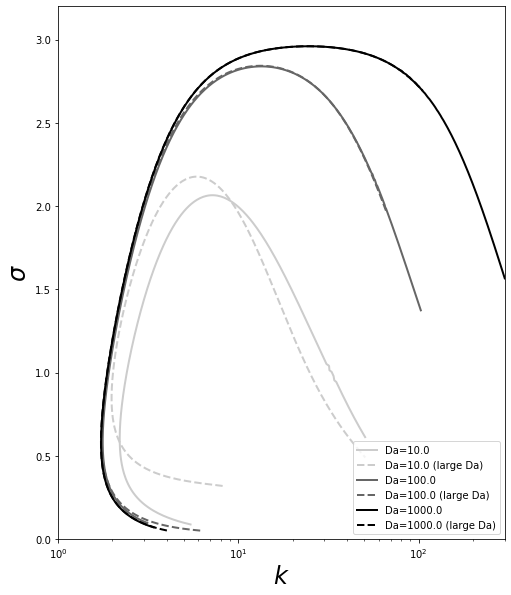

In [25]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

for vals, gray in zip([10., 100., 1000.], [0.8, 0.4, 0.0]):
    plt.plot(DC_cube[vals].k, DC_cube[vals].s, '-', linewidth=2, 
             color=[gray, gray, gray], label=r'Da='+str(vals))
    plt.plot(DC_quad[vals].k, DC_quad[vals].s, '--', linewidth=2, 
             color=[gray, gray, gray], label=r'Da=' + str(vals) + ' (large Da)')

plt.xscale('log')
plt.xlim(1, 300)
plt.xlabel(r'$k$', fontsize=24)
plt.ylim(0, 3.2)
plt.ylabel(r'$\sigma$', fontsize=24)
plt.legend()
plt.show()


### A modified problem and its analytical solution

In [5]:
class PAR:
    def __init__(self):
        self.s = None
        self.k = None
        self.smax = None
        self.kmax = None
        self.X = None
        self.Y = None
        self.P = None
        self.phi = None
        self.U = None
        self.W = None

        
def ReactiveFlowAnalyticalSolution(k, n, Da, Pe, S):
    K = (1 + k**2 / Da / Pe).astype(np.clongdouble)
    b = np.pi
    # growth rate - upper branch
    full = np.zeros((k.shape[0], 2), dtype=np.clongdouble)
    b2 = b ** 2
    Da2 = Da ** 2
    Da3 = Da ** 3
    Da4 = Da ** 4
    K2 = K ** 2
    K4 = K ** 4
    k2 = k ** 2
    k4 = k ** 4
    k6 = k ** 6
    S2 = S ** 2
    full[:, 0] = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                    - 3.0 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                  + 4 * Da * K * b2 * n + Da * K * k2 * n + 2 * Da2 * K * S * k2 * n) / (
            4 * S * Da2 * K2 * b2 + 4 * S * Da2 * K2 * k2 + S * k4)
    # lower branch
    full[:, 1] = -(2.0 * n * np.sqrt(- Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                     - 3 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                   - K * (4 * Da * n * b2 + n * (2 * S * Da2 + Da) * k2)) / (
            S * (4 * Da2 * K2 * b2 + 4 * Da2 * K2 * k2 + k4))

    real1 = np.nonzero(np.imag(full[:, 0]).astype(np.float32) == 0.0)
    real2 = np.nonzero(np.imag(full[:, 1]).astype(np.float32) == 0.0)
    s = PAR()
    s.s = np.real(np.concatenate((np.flipud(full[real1, 0].flatten()), full[real2, 1].flatten())))
    s.k = np.real(np.concatenate((np.flipud(k[real1].flatten()), k[real2].flatten())))
    I = np.argmax(s.s)
    s.smax = s.s[I]
    s.kmax = s.k[I]

    # eigenfunctions
    K = 1 + s.kmax ** 2 / Da / Pe
    a = 0.5 * (n * K / S + s.smax * s.kmax ** 2 / Da) / (s.smax * K - n / Da / S)
    m = a + 1j * np.pi
    lambda_ = 2 * np.pi / s.kmax
    x = np.linspace(0, 2 * lambda_, 1000)
    hx = x[2]-x[1]
    y = np.linspace(0, 1, 1000)
    hy = y[2]-y[1]
    s.X, s.Y = np.meshgrid(x, y)
    s.P = np.exp(a * s.Y) * np.sin(np.pi * s.Y) * np.sin(s.kmax * s.X)
    tmp = np.exp(a * s.Y) * np.cos(np.pi * s.Y) * np.sin(s.kmax * s.X)
    dphi_dy = S * ((a ** 2 - np.pi ** 2 - s.kmax ** 2) * s.P + 2 * a * np.pi * tmp) / n
    s.phi = np.cumsum(dphi_dy, axis=0) * hy

    Px, Py = np.gradient(s.P, hx, hy)
    s.U = -S * Px
    s.W = (n - 1) * s.phi - S * Py

    s.P = (s.P - np.amin(s.P)) / (np.amax(s.P) - np.amin(s.P))
    s.phi = (s.phi - np.amin(s.phi)) / (np.amax(s.phi) - np.amin(s.phi))
    
    return s

In [6]:
n = 3.
Da = 1000.
Pe = 100.
S = np.asarray([0.01, 0.1, 1, 10]).astype(np.clongdouble)
k = np.logspace(-1.0, 4.0, 10000).astype(np.clongdouble)
s = []

for s_ in S:
    s.append(ReactiveFlowAnalyticalSolution(k, n, Da, Pe, s_))

## Application to the mantle